# Diffusion of a Gaussian profile on an interval

$$
\mathbb{S}
\begin{cases}
\Omega = [0, L_x] \\
u_{\text{D}}(x=0) = 0 \\
u_{\text{D}}(x=L_x) = 0 \\
\mathsf{D}=D\mathsf{I} \\
\end{cases}
$$

In [1]:
import numpy as np
from lucifex.mesh import interval_mesh, mesh_boundary
from lucifex.fdm import BE, FunctionSeries, diffusive_timestep
from lucifex.fem import Constant
from lucifex.solver import ibvp, BoundaryConditions
from lucifex.viz import plot_line, create_animation, save_figure, display_animation
from lucifex.pde.diffusion import diffusion


Nx = 100
Lx = 2.0
mesh = interval_mesh(Lx, 100)
boundary = mesh_boundary(
    mesh, 
    {
        "left": lambda x: x[0],
        "right": lambda x: x[0] - Lx,
    },
)

dt = Constant(mesh, 0.01, name='dt')
d = Constant(mesh, 1.0, name='d')
D_diff = BE

h = Lx/ Nx
dt_courant = diffusive_timestep(d, h)
courant = dt.value / dt_courant

ics = lambda x: np.exp(-(x[0] - Lx/2)**2 / (0.01 * Lx))
bcs =  BoundaryConditions(
    ("dirichlet", boundary['left', 'right'], 0.0), 
)
u = FunctionSeries((mesh, 'P', 1), name='u', store=1)
w = FunctionSeries((mesh, 'P', 1), name='w', store=1)
u_solver = ibvp(diffusion, ics, bcs)(u, dt, d, D_diff)

In [2]:
t = 0.0
t_stop = 10.0
n = 0
n_stop = 10

while n < n_stop and t < t_stop:
    u_solver.solve()
    u.forward(t)
    t += dt.value
    n += 1

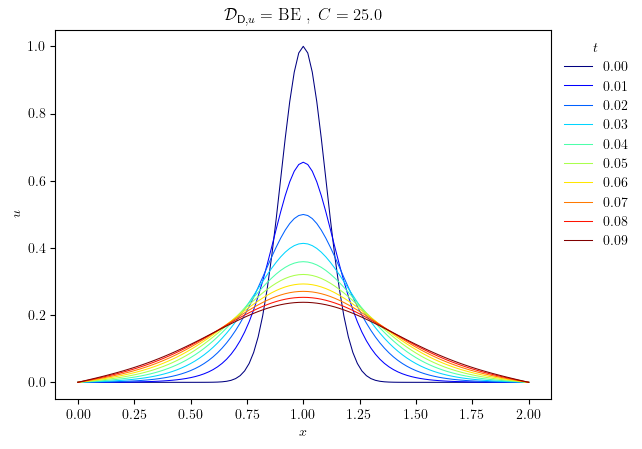

In [3]:
time_slice = slice(0, None)
title = f"$\mathcal{{D}}_{{\mathsf{{D}}, u}}=\\mathrm{{{str(D_diff)}}}~,~C={courant}$"
legend_labels = [f'{t:.2f}' for t in u.time_series[time_slice]]
legend_title = '$t$'
fig, ax = plot_line(
    u.series[time_slice], legend_labels, legend_title, 
    cyc='jet', x_label='$x$', y_label='$u$', title=title,
)
save_figure('u(x,t)')(fig)

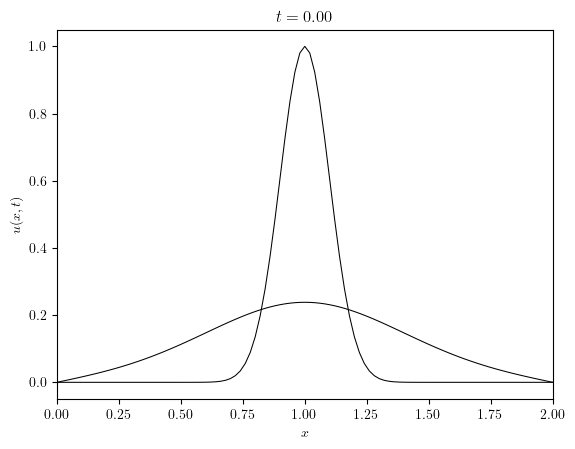

In [4]:
title_series = [f'$t={t:.2f}$' for t in u.time_series]

anim = create_animation(
    plot_line,
    x_label='$x$',
    y_label='$u(x,t)$',
)(u.series, title=title_series)
anim_path = save_figure('u(x,t)', get_path=True)(anim)

display_animation(anim_path)